In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path

In [3]:
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()]) #,normalize])


#dataset = datasets.ImageFolder("C:/Users/lisec/OneDrive/Documents/cours/5A/AIF/Projet/content/sorted_movie_posters_paligema", transform = transform)
dataset = datasets.ImageFolder("./content/sorted_movie_posters_paligema", transform = transform)

train_size = int(0.8 * len(dataset))  # 80% pour l'entraînement
test_size = len(dataset) - train_size  # 20% pour le test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])



train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)  
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

#dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

(np.float64(-0.5), np.float64(1809.5), np.float64(453.5), np.float64(-0.5))

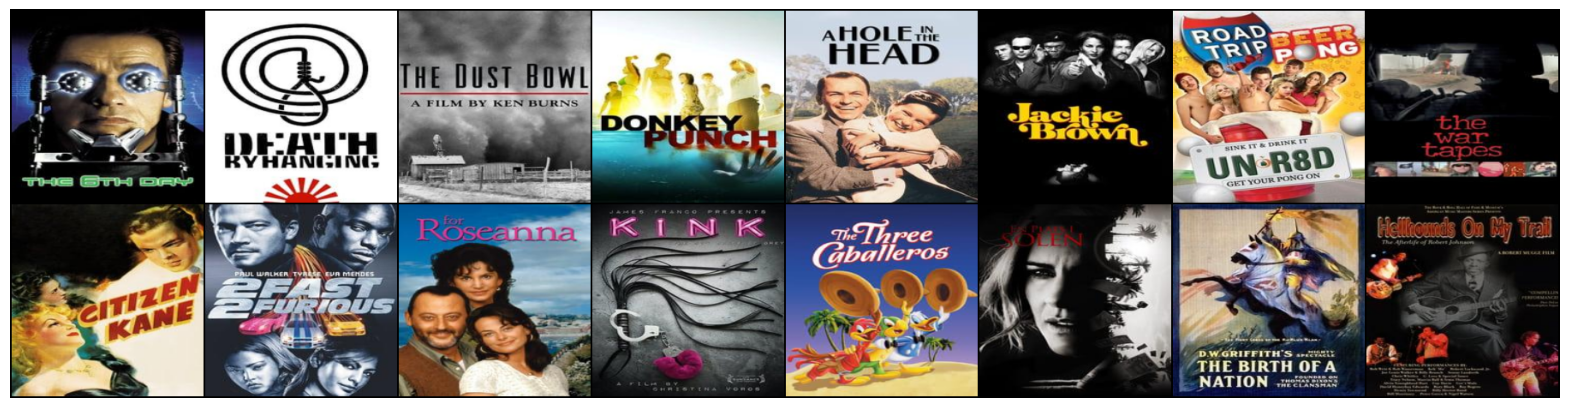

In [4]:
x, paths = next(iter(train_dataloader))
img_grid = make_grid(x[:16])
#img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

In [5]:
# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), # 224x224 -> 112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 112x112 -> 56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 56x56 -> 28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 28x28 -> 14x14
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 56x56 -> 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 112x112 -> 224x224
            nn.Sigmoid() # Normalize to [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
train = False

# Training Loop
if train :
    torch.cuda.empty_cache()
    epochs = 50
    for epoch in range(epochs):
        for images, _ in train_dataloader:
            images = images.to(device)
            
            # Forward Pass
            reconstructed = model(images)
            loss = criterion(reconstructed, images)
            
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [7]:
if train :
    # Save Model
    torch.save(model.state_dict(), 'autoencoder_film_posters.pth')
else :
    model.load_state_dict(torch.load('autoencoder_film_posters.pth', weights_only=True))

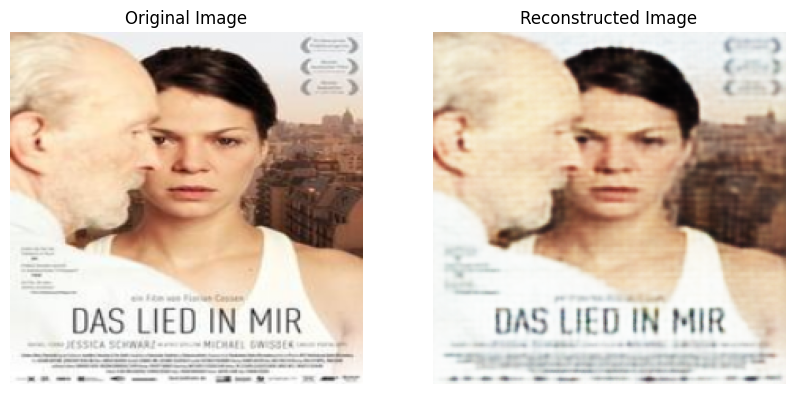

In [8]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Function to visualize original and reconstructed images
def visualize_reconstruction(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    images, _ = next(iter(dataloader))  # Get a batch of images
    images = images.to(device)
    
    # Pass through the autoencoder
    with torch.no_grad():
        reconstructed = model(images)
    
    # Select a random index
    random_idx = random.randint(0, len(images) - 1)
    original_image = images[random_idx].cpu().permute(1, 2, 0)  # Move channels to last dimension
    reconstructed_image = reconstructed[random_idx].cpu().permute(1, 2, 0)

    # Plot original and reconstructed images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original image
    axes[0].imshow(original_image.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Reconstructed image
    axes[1].imshow(reconstructed_image.numpy())
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")
    
    plt.show()

# Example Usage
# Assuming `model` is your trained autoencoder and `dataloader` provides images
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_reconstruction(model, test_dataloader, device)

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
"""
# Télécharger les données CIFAR-10
anomaly_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

anomaly_dataloader = DataLoader(anomaly_dataset, batch_size=64, shuffle=False)"""

stl10_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)

Files already downloaded and verified


torch.Size([32, 3, 224, 224])


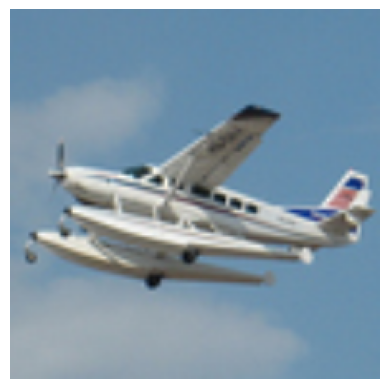

In [40]:
indices = list(range(test_size))
subset_dataset = Subset(stl10_dataset, indices)
anomaly_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

# Visualisation
import matplotlib.pyplot as plt
images, labels = next(iter(anomaly_loader))
print(images.shape)
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

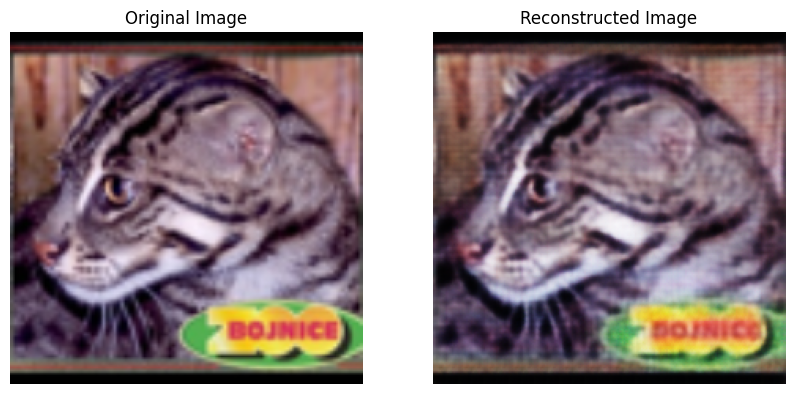

In [11]:
#visualize_reconstruction(model, anomaly_dataloader, device)

visualize_reconstruction(model, anomaly_loader, device)

In [12]:
import torch
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(poster_loader, anomaly_loader, model, threshold):
    """
    Computes the confusion matrix for an anomaly detection model.
    
    Parameters:
        poster_loader (DataLoader): DataLoader containing poster images.
        anomaly_loader (DataLoader): DataLoader containing anomaly images.
        model (torch.nn.Module): Trained autoencoder model.
        threshold (float): Reconstruction error threshold to classify anomalies.

    Returns:
        dict: Confusion matrix with keys: 'TP', 'TN', 'FP', 'FN'.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Helper function to calculate reconstruction error
    def calculate_error(input_image):
        input_image = input_image.to(device)
        with torch.no_grad():
            reconstructed = model(input_image)
        error = torch.mean((input_image - reconstructed) ** 2, dim=[1, 2, 3])  # Per-image MSE
        return error.cpu()
    
    # Initialize lists to store errors and labels
    errors = []
    labels = []  # 1 for poster, 0 for anomaly
    
    # Process poster images (label = 1)
    for batch in poster_loader:
        images, _ = batch  # Assuming loader returns (images, labels)
        errors.extend(calculate_error(images).numpy())
        labels.extend([1] * len(images))
    
    # Process anomaly images (label = 0)
    for batch in anomaly_loader:
        images, _ = batch
        errors.extend(calculate_error(images).numpy())
        labels.extend([0] * len(images))
    
    # Convert lists to tensors
    errors = torch.tensor(errors)
    labels = torch.tensor(labels)
    
    # Predict labels based on the threshold
    predictions = (errors > threshold).int()  # 1 if below threshold (poster), 0 otherwise
    
    # Compute confusion matrix components
    cm = confusion_matrix(labels, predictions, labels=[1, 0])
    print(labels)
    print(predictions)
    TP, FN = cm[0]
    FP, TN = cm[1]
    
    # Return the confusion matrix as a dictionary
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

threshold = 0.001  # Example threshold for reconstruction error

conf_matrix = compute_confusion_matrix(test_dataloader, anomaly_loader, model, threshold)
print(conf_matrix)

tensor([1, 1, 1,  ..., 0, 0, 0])
tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.int32)
{'TP': np.int64(1025), 'TN': np.int64(967), 'FP': np.int64(108), 'FN': np.int64(50)}


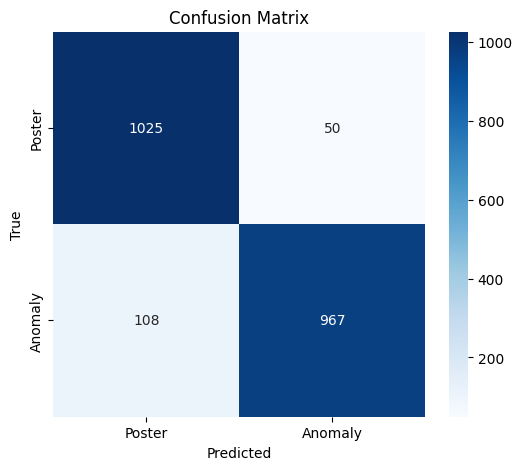

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix_from_dict(cm_dict, labels=None):
    """
    Plots the confusion matrix from a dictionary with 'TP', 'TN', 'FP', 'FN'.
    
    Parameters:
        cm_dict (dict): Confusion matrix dictionary with keys ['TP', 'TN', 'FP', 'FN'].
        labels (list): Optional list of label names (default is [0, 1]).
    """
    # Extract values from the dictionary
    TP = cm_dict.get('TP', 0)
    TN = cm_dict.get('TN', 0)
    FP = cm_dict.get('FP', 0)
    FN = cm_dict.get('FN', 0)
    
    # Construct the confusion matrix as a 2x2 array
    cm = np.array([[TP, FN],
                   [FP, TN]])

    # Plotting the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    
    # Add titles and labels
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Optional: Define your labels (if binary, you can use [0, 1])
labels = ['Poster', 'Anomaly']

# Plot the confusion matrix
plot_confusion_matrix_from_dict(conf_matrix, labels)

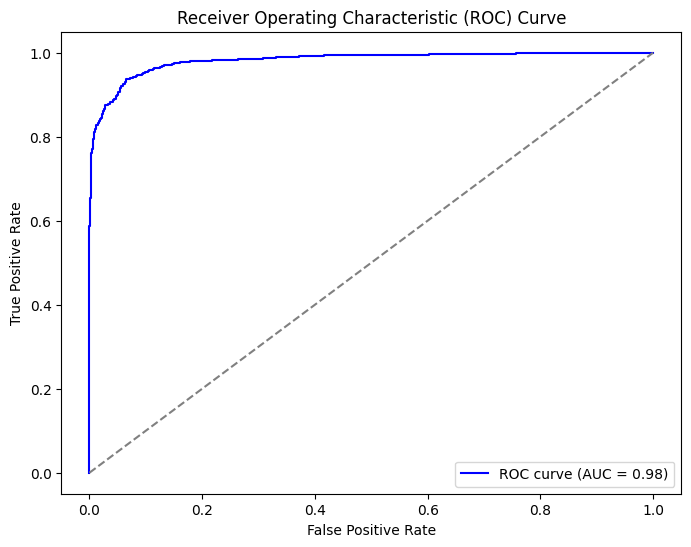

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader

def compute_reconstruction_error(model, data_loader, device):
    """
    Computes the reconstruction error for a given dataset using the autoencoder model.
    
    Parameters:
        model (torch.nn.Module): The trained autoencoder model.
        data_loader (DataLoader): DataLoader for the dataset (either normal or anomaly).
        device (torch.device): The device (CPU or GPU) to use for computation.
        
    Returns:
        errors (list): List of reconstruction errors for the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    errors = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = model(images)
            
            # Compute reconstruction error (mean squared error)
            error = torch.mean((reconstructed - images) ** 2, dim=(1, 2, 3))  # MSE per image
            errors.extend(error.cpu().numpy())  # Store the errors

    return np.array(errors)


def plot_roc_curve_from_autoencoder(model, poster_loader, anomaly_loader, device):
    """
    Plots the ROC curve for the autoencoder model using the reconstruction error as the anomaly score.
    
    Parameters:
        model (torch.nn.Module): The trained autoencoder model.
        poster_loader (DataLoader): DataLoader for the normal images (posters).
        anomaly_loader (DataLoader): DataLoader for the anomalous images.
        device (torch.device): The device (CPU or GPU) to use for computation.
    """
    # Compute reconstruction errors for the poster (normal) and anomaly datasets
    poster_errors = compute_reconstruction_error(model, poster_loader, device)
    anomaly_errors = compute_reconstruction_error(model, anomaly_loader, device)
    
    # Create the true labels for the ROC curve
    true_labels = np.array([1] * len(poster_errors) + [0] * len(anomaly_errors))
    
    # Combine the errors from both datasets
    predicted_scores = np.concatenate([poster_errors, anomaly_errors])
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
    
    # Compute the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return fpr, tpr, thresholds, roc_auc

# Example usage:
# model = ...  # Your trained autoencoder model
# poster_loader = ...  # DataLoader for your poster images (normal class)
# anomaly_loader = ...  # DataLoader for your anomaly images (negative class)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Call the function
fpr, tpr, thresholds, roc_auc = plot_roc_curve_from_autoencoder(model, test_dataloader, anomaly_loader, device)


In [15]:
small_indices = list(range(int(train_size/100)))
small_subset_dataset = Subset(stl10_dataset, small_indices)
small_anomaly_loader = DataLoader(small_subset_dataset, batch_size=32, shuffle=True)

In [16]:
# ---- 4. Obtenir les embeddings avec le modèle ----
def get_embeddings(dataloader, model):
    model.eval()
    embeddings_list = []
    with torch.no_grad():
        for images, _ in dataloader:
            embeddings = model.encoder(images.to(device))  # Obtenir les embeddings
            embeddings = embeddings.view(images.size(0), -1)  # Aplatir
            embeddings_list.append(embeddings.cpu().numpy())  # Ajouter au tableau final
    return np.vstack(embeddings_list)  # Combiner tous les batches

# Obtenir les embeddings
embeddings_normal = get_embeddings(train_dataloader, model)
embeddings_anomalies = get_embeddings(small_anomaly_loader, model)

print("Embeddings normaux :", embeddings_normal.shape)  # [N, D]
print("Embeddings anomalies :", embeddings_anomalies.shape)  # [M, D]

Embeddings normaux : (4300, 100352)
Embeddings anomalies : (43, 100352)


In [17]:
from sklearn.svm import SVC

# Combiner les données
X = np.vstack([embeddings_normal, embeddings_anomalies])
y = np.hstack([np.zeros(len(embeddings_normal)), np.ones(len(embeddings_anomalies))])  # 0: normal, 1: anomalie

# Entraîner le SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Tester le modèle
y_pred = svm.predict(X)
print(y_pred)


[0. 0. 0. ... 1. 1. 1.]


In [18]:
print(np.sum(y==y_pred))
print(np.sum(y!=y_pred))

4343
0


In [19]:
test_indices = list(range(int(train_size/100),int(train_size/100)+len(test_dataset)))
test_subset_dataset = Subset(stl10_dataset, test_indices)
test_anomaly_loader = DataLoader(test_subset_dataset, batch_size=32, shuffle=True)

In [20]:
from sklearn.metrics import classification_report, accuracy_score

# ---- 3. Obtenir les embeddings de test ----
test_embeddings_normal = get_embeddings(test_dataloader, model)
test_embeddings_anomalies = get_embeddings(test_anomaly_loader, model)

# ---- 4. Préparer les données pour le SVM ----
X_test = np.vstack([test_embeddings_normal, test_embeddings_anomalies])
y_test = np.hstack([np.zeros(len(test_embeddings_normal)), np.ones(len(test_embeddings_anomalies))])  # 0: normal, 1: anomalie

# ---- 5. Prédictions du SVM ----
y_pred = svm.predict(X_test)

# ---- 6. Évaluer le SVM ----
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      1075
         1.0       0.96      0.10      0.18      1075

    accuracy                           0.55      2150
   macro avg       0.75      0.55      0.44      2150
weighted avg       0.75      0.55      0.44      2150

Accuracy: 54.88%


In [21]:
print(np.sum(y_test==y_pred))
print(np.sum(y_test!=y_pred))
print(y_test[y_test!=y_pred])
print(len(test_indices))

1180
970
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [22]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

MODEL_PATH = 'model_genre_classifier.pth'
GENRES = ['action', 'comedy', 'animation', 'documentary', 'drama', 'fantasy', 'horror', 'romance', 'science Fiction', 'thriller']

mobilenet = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model = nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool,
    nn.Flatten(),
    nn.Linear(576, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(GENRES))
)
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
model = model.to(device)
#model.eval()

In [23]:
images, _ = next(iter(train_dataloader))
print(model(images.to(device)).shape)

torch.Size([128, 10])


In [24]:
# MLS Score
def mls(logits):
    scores = - torch.max(logits, dim=1)[0]
    return scores.cpu().numpy()

# MSP Score
def msp(logits):
    probas = torch.softmax(logits, dim=1)
    max_probas_scores = - torch.max(probas, dim=1)[0]
    return max_probas_scores.cpu().numpy()

# Energy Score
def energy(logits, temp=1):
    energies = - temp * torch.logsumexp(logits / temp, dim=1)
    return energies.cpu().numpy()

# Entropy Score
def entropy(logits):
    probas = torch.softmax(logits, dim=1)
    entropies = - torch.sum(probas * torch.log(probas + 1e-8), dim=1)
    return entropies.cpu().numpy()

In [25]:
# TPR and FPR

def confusion_matrix(scores_negatives, scores_positives, threshold):
    false_positives = np.sum(scores_negatives > threshold)
    true_postives = np.sum(scores_positives > threshold)
    true_negatives = np.sum(scores_negatives <= threshold)
    false_negatives = np.sum(scores_positives <= threshold)
    return false_positives, true_postives, true_negatives, false_negatives

def tpr_fpr(scores_negatives, scores_positives, threshold):
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

def accuracy(scores_negatives, scores_positives, threshold):
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    return (tp + tn) / (tp + tn + fp + fn)

def precision_recall(scores_negatives, scores_positives, threshold):
    fp, tp, tn, fn = confusion_matrix(scores_negatives, scores_positives, threshold)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

def f_beta(scores_negatives, scores_positives, threshold, beta):
    precision, recall = precision_recall(scores_negatives, scores_positives, threshold)
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

In [26]:
def roc_auc(scores_negatives, scores_positives):
    # Combine scores and create labels
    scores = np.concatenate((scores_negatives, scores_positives))
    labels = np.concatenate((np.zeros(len(scores_negatives)), np.ones(len(scores_positives))))

    # Sort scores and labels
    sorted_indices = np.argsort(scores)
    scores = scores[sorted_indices]
    labels = labels[sorted_indices]

    # Initialize TPR and FPR
    tpr = []
    fpr = []
    n_pos = np.sum(labels)
    n_neg = len(labels) - n_pos

    tp = n_pos
    fp = n_neg

    # Compute TPR and FPR at each threshold
    for i in range(len(scores)):
        if labels[i] == 1:  # True positive
            tp -= 1
        else:  # False positive
            fp -= 1
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)

    tpr = np.array(tpr)
    fpr = np.array(fpr)

    # Compute AUROC (Area Under the Curve)
    auroc = - np.trapz(tpr, fpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return auroc

In [27]:
def compute_threshold(scores, target_tpr=0.95):
    sorted_scores = np.sort(scores)
    target_index = int(np.ceil((1-target_tpr) * len(sorted_scores))) - 1

    # Handle edge cases
    target_index = max(0, target_index)  # Ensure index is non-negative
    target_index = min(len(sorted_scores) - 1, target_index)  # Ensure index is within bounds

    # Select the threshold
    threshold = sorted_scores[target_index]

    return threshold

In [37]:
target_tpr = 0.9
metrics_dict = {}

In [38]:
# Compute logits directly from the dataset
def compute_logits(dataset, model, device):
    all_logits = []
    with torch.no_grad():
        for i in range(len(dataset)):
            image, _ = dataset[i]  # Get each image directly from the dataset
            image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            logits = model(image)
            all_logits.append(logits)
    return torch.cat(all_logits, dim=0)  # Concatenate all logits into a single tensor

# Apply the function to posters (negatives) and life content (ood/positives) datasets
test_logits_negatives = compute_logits(test_dataset, model, device)
test_logits_positives = compute_logits(test_subset_dataset, model, device)

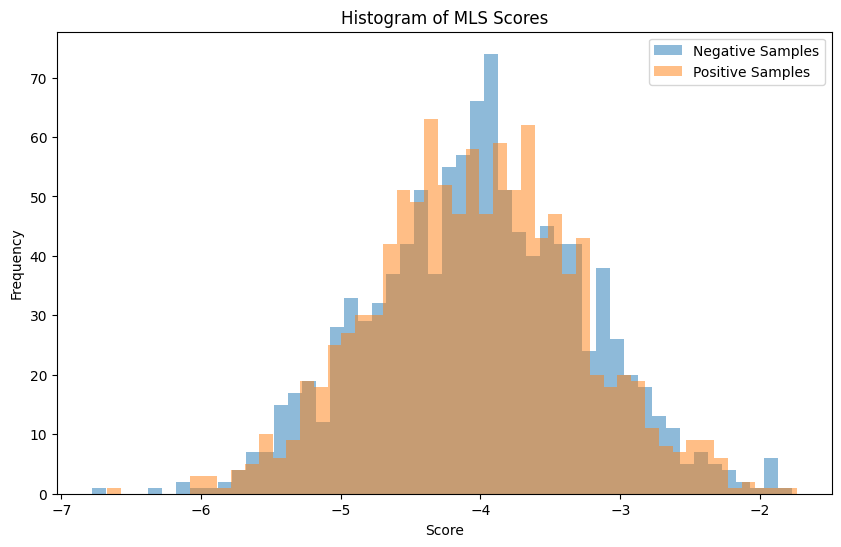

/tmp/ipykernel_7200/3575561754.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auroc = - np.trapz(tpr, fpr)


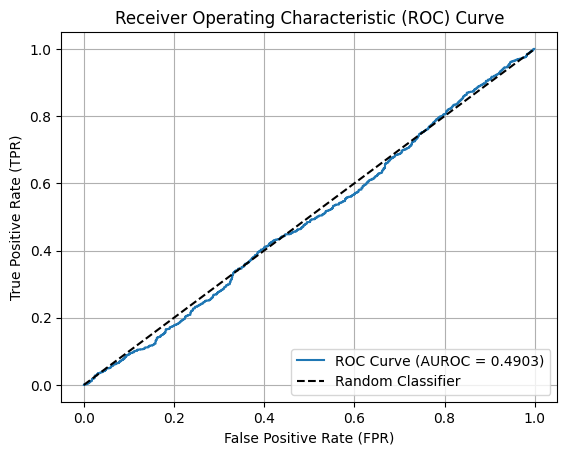

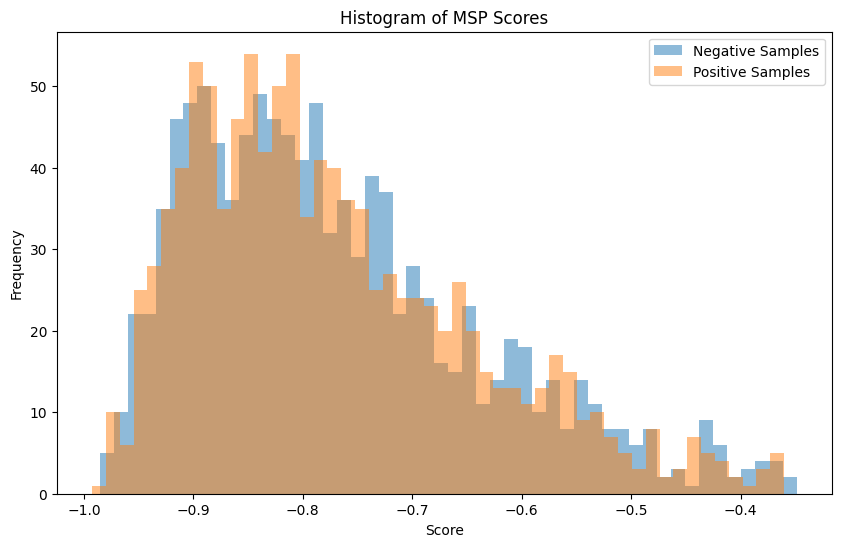

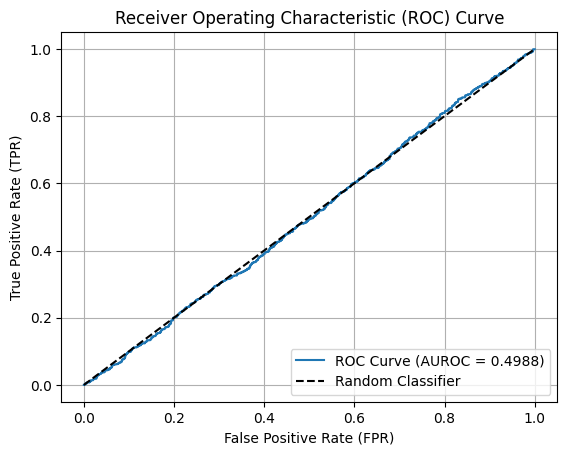

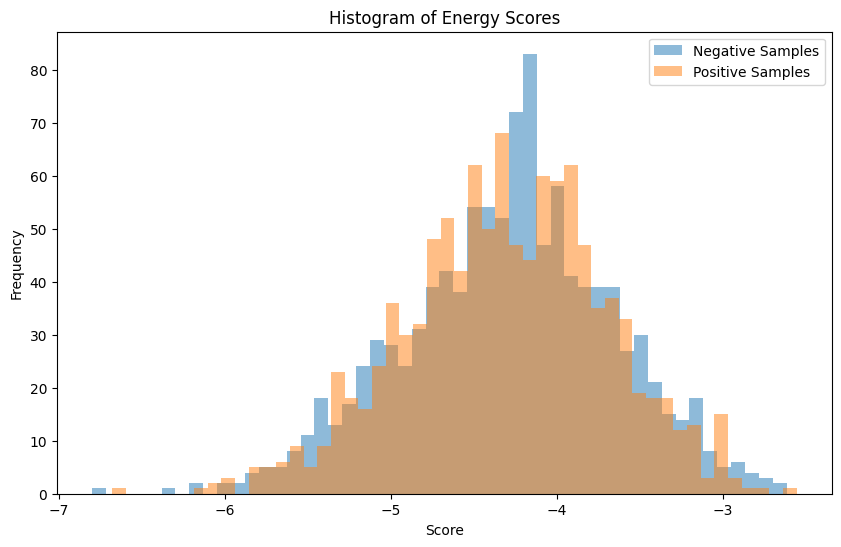

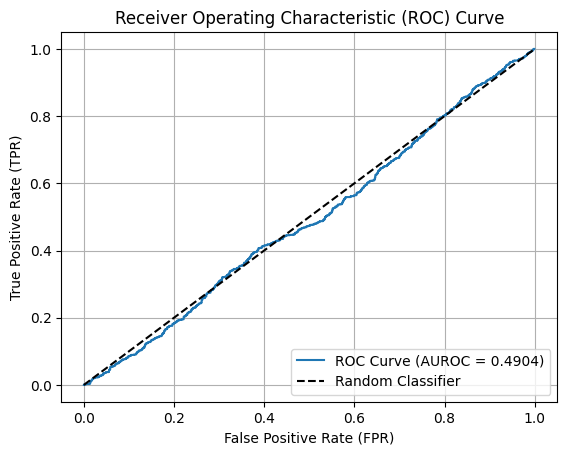

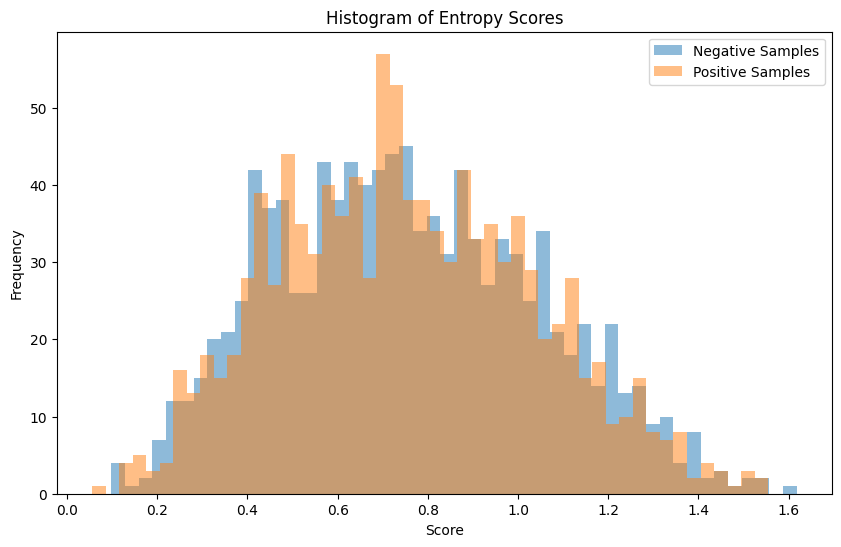

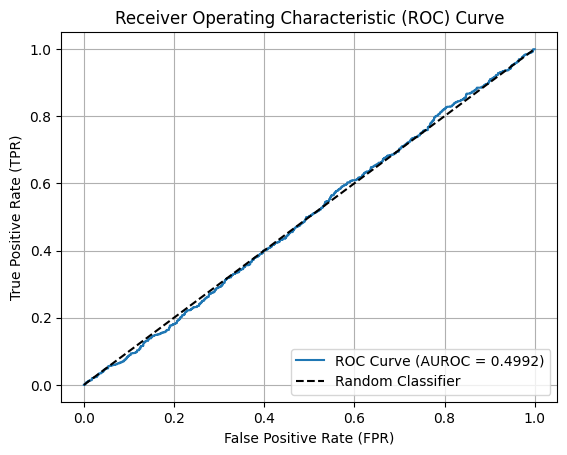

In [39]:
scoring_functions = {
    'MLS': mls,
    'MSP': msp,
    'Energy': energy,
    'Entropy': entropy
}

for method, scoring_function in scoring_functions.items():

    # Compute scores
    scores_negatives = scoring_function(test_logits_negatives)
    scores_positives = scoring_function(test_logits_positives)

    # Plot histogram of scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores_negatives, bins=50, alpha=0.5, label='Negative Samples')
    plt.hist(scores_positives, bins=50, alpha=0.5, label='Positive Samples')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {method} Scores')
    plt.legend()
    plt.show()

    # Initialize empty dict for metrics
    metrics_dict[method] = {}

    # Plot ROC curve and compute AUROC
    auroc = roc_auc(scores_negatives, scores_positives)
    metrics_dict[method]['auroc'] = auroc

    # Compute threshold for the given target_tpr
    threshold = compute_threshold(scores_positives, target_tpr)

    # Compute and store remaining metrics
    metrics_dict[method]['accuray'] = accuracy(scores_negatives, scores_positives, threshold)
    metrics_dict[method]['tpr'], metrics_dict[method]['fpr'] = tpr_fpr(scores_negatives, scores_positives, threshold)
    metrics_dict[method]['precision'], metrics_dict[method]['recall'] = precision_recall(scores_negatives, scores_positives, threshold)
    metrics_dict[method]['f1'] = f_beta(scores_negatives, scores_positives, threshold, beta=1)